# Large experiment for HPL on Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

df = pandas.concat([
    read_result('grenoble_2018-10-10_1811810.zip'),
])
df.head()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,proc_q,depth,proc_p,pfact,bcast,swap,time,mem_align,residual,gflops,thread_per_process,matrix_size,process_per_node,rfact,block_size
0,32,1,32,1,2,0,16.03,8,0.000928,17540.0,1,75000,32,2,128
1,32,1,32,1,2,0,326.05,8,0.000612,23290.0,1,225000,32,2,128
2,32,1,32,1,2,0,160.53,8,0.000827,22260.0,1,175000,32,2,128
3,32,1,32,1,2,0,62.02,8,0.000793,20990.0,1,125000,32,2,128
4,32,1,32,1,2,0,440.78,8,0.000563,23630.0,1,250000,32,2,128


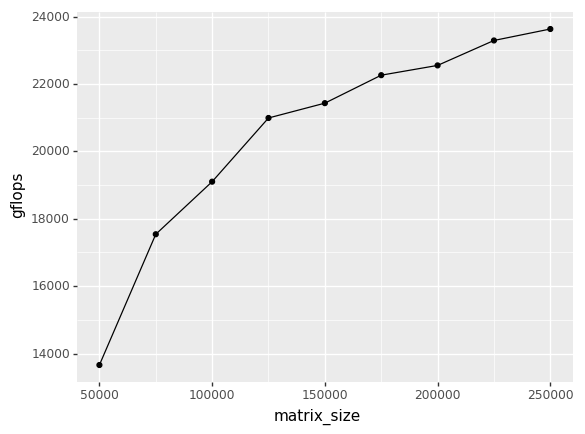

<ggplot: (-9223363249834338111)>

In [2]:
ggplot(df, aes(x='matrix_size', y='gflops')) + geom_line() + geom_point()

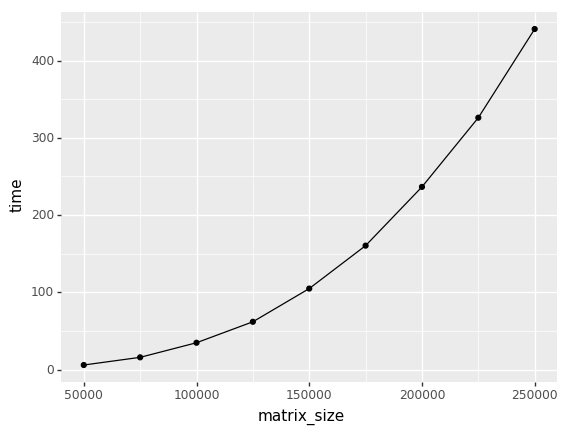

<ggplot: (8787020405375)>

In [3]:
ggplot(df, aes(x='matrix_size', y='time')) + geom_line() + geom_point()

In [4]:
df[df.matrix_size == df.matrix_size.max()]

,proc_q,depth,proc_p,pfact,bcast,swap,time,mem_align,residual,gflops,thread_per_process,matrix_size,process_per_node,rfact,block_size
4,32,1,32,1,2,0,440.78,8,0.000563,23630.0,1,250000,32,2,128


## Extrapolation

Used to determine the walltime of the jobs I submit on G5K.

HPL time complexity is $\mathcal{O}\left(\frac{2}{3}n^3 + 2n^2\right)$

[source](https://en.wikipedia.org/wiki/LINPACK_benchmarks#LINPACK_100)

In [5]:
import statsmodels.formula.api as sm
reg = sm.ols(data=df, formula='time ~ I(matrix_size**3) + I(matrix_size**2)').fit()
reg.summary()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.556e+05
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           1.78e-16
Time:                        13:37:28   Log-Likelihood:                -12.409
No. Observations:                   9   AIC:                             28.82
Df Residuals:                       7   BIC:                             29.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.163e-19   7.24e-21     16.062      0.000    9.92e-20    1.33e-19
I(matrix_size ** 3)  2.394e-14   3.02e-16     79.393      0.000    2.32e-14    2.47e-14
I(matrix_size ** 2)   1.07e-09   6.66e-11     16.062      0.000    9.13e-10    1.23e-09
==============================================================================
Omnibus:                        5.171   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                1.473
Skew:                           0.907   Prob(JB):                        0.479
Kurtosis:                       3.798   Cond. No.                     1.99e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
tmp = df[['matrix_size', 'time', 'gflops']].copy()
tmp['mode'] = 'real'
tmp2 = pandas.DataFrame([{'matrix_size': n, 'time':-1} for n in range(100, 1000000, 100)])
tmp2['time'] = reg.predict(tmp2)
tmp2['mode'] = 'extrapolation'
tmp2['gflops'] = ((2/3)*tmp2.matrix_size**3 + 2*tmp2.matrix_size**2) / tmp2.time * 1e-9
tmp = pandas.concat([tmp, tmp2])

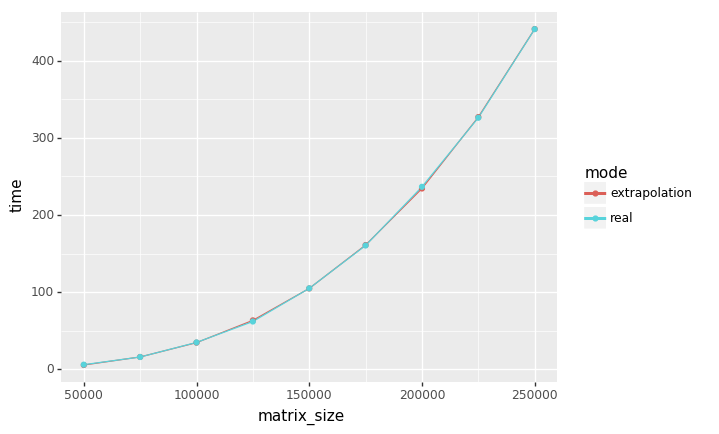

<ggplot: (8787018204918)>

In [7]:
ggplot(tmp[tmp.matrix_size.isin(df.matrix_size)], aes(x='matrix_size', y='time', color='mode')) + geom_line() + geom_point()

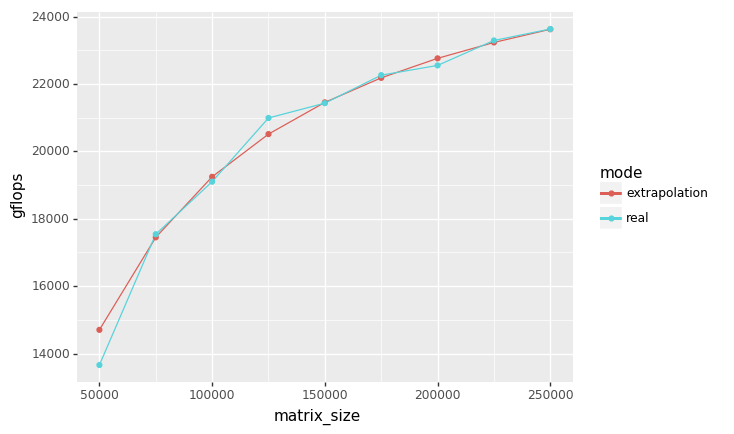

<ggplot: (8787017992340)>

In [8]:
ggplot(tmp[tmp.matrix_size.isin(df.matrix_size)], aes(x='matrix_size', y='gflops', color='mode')) + geom_line() + geom_point()

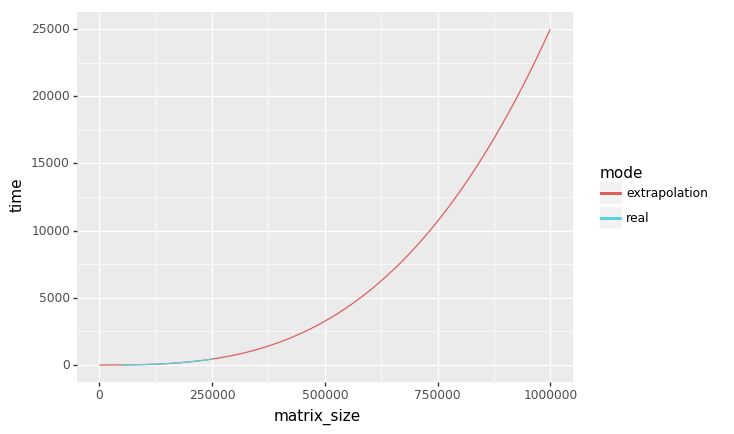

<ggplot: (-9223363249836570978)>

In [9]:
ggplot(tmp, aes(x='matrix_size', y='time', color='mode')) + geom_line()

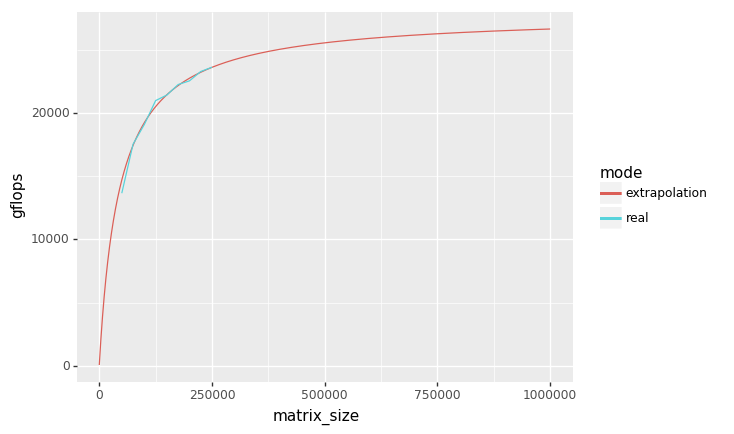

<ggplot: (8787017992249)>

In [10]:
ggplot(tmp, aes(x='matrix_size', y='gflops', color='mode')) + geom_line()

In [11]:
def time_to_str(time):
    h = time//3600
    time -= h*3600
    m = time//60
    time -= m*60
    s = time
    return '%02d:%02d:%02d' % (h, m, s)

def estimate(df, sizes):
    tmp = df[df.matrix_size.isin(sizes)]
    time = int(tmp.time.sum())
    print(time_to_str(time))
    return time
    
estimate(tmp[tmp['mode'] == 'real'], range(50000, 250001, 25000))

00:23:07


1387

In [12]:
time_to_str(df.time.sum())

'00:23:07'

In [13]:
estimate(tmp[tmp['mode'] == 'extrapolation'], range(50000, 250001, 25000))

00:23:08


1388

In [14]:
estimate(tmp[tmp['mode'] == 'extrapolation'], range(300000, 500001, 50000))

02:34:22


9262